In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
import nltk
nltk.download('punkt')
import wordcloud
%matplotlib inline
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/divyatmika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_excel('Online Retail.xlsx', dtype={'StockCode':str})
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [3]:
data.shape

(541909, 8)

In [4]:
# Checking for null values.
info = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,1454.000000,0.0,0.0,0.0,135080.000000,0.0
% Null values,0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


In [5]:
# Removing null values
data.dropna(axis=0, subset = ['CustomerID'], inplace=True)
info = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Checking for Duplicates :
data.duplicated().sum()

5225

In [7]:
# Removing duplicate entries :
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

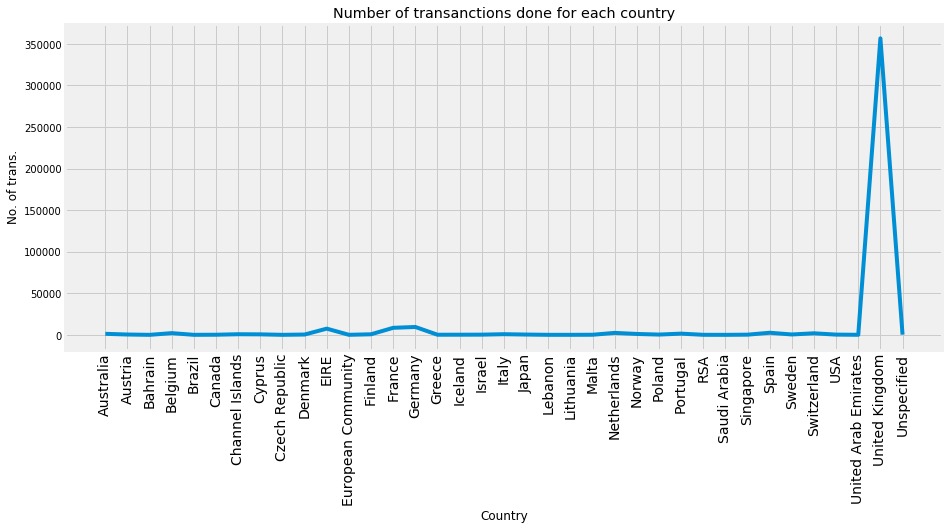

In [8]:
plt.figure(figsize=(14,6))
plt.plot(data.groupby(['Country']).groups.keys(), data.groupby(['Country'])['CustomerID'].count())
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Number of transanctions done for each country")
plt.ylabel("No. of trans.")
plt.xlabel("Country")
plt.show()

In [9]:
info = pd.DataFrame(data = data.groupby(['Country'])['InvoiceNo'].nunique(), index=data.groupby(['Country']).groups.keys()).T
info

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceNo,69,19,2,119,1,6,33,20,5,21,...,1,2,10,105,46,71,7,3,19857,8


In [10]:
# StockCode Feature ->
# We will see how many different products were sold in the year data was collected.
print(len(data['StockCode'].value_counts()))

3684


In [11]:
# Transanction feature
# We will see how many different transanctions were done.
print(len(data['InvoiceNo'].value_counts()))

22190


In [12]:
# Transanction feature
# We will see how many different Customers are there.
print(len(data['CustomerID'].value_counts()))

4372


In [13]:
pd.DataFrame({'products':len(data['StockCode'].value_counts()),
              'transanctions':len(data['InvoiceNo'].value_counts()),
              'Customers':len(data['CustomerID'].value_counts())},
             index = ['Quantity'])

,products,transanctions,Customers
Quantity,3684,22190,4372


There are 22k transanctions but only 4k customers with 3.5k products. It seems that some orders were placed then cancelled or the customers bought items multiple times or multiple items were bought in a single transanction.

In [14]:
##### Checking the number of items bought in a single transanctions :

In [15]:
df = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
df = df.rename(columns = {'InvoiceDate':'Number of products'})
df[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


There are customers who purchase only 1 item per transanction and others who purchase many items per transanction. Also there are some orders which were cancelled they are marked with 'C' in the beginning.

In [17]:
df['orders cancelled'] = df['InvoiceNo'].apply(lambda x: int('C' in str(x)))
df.head()

,CustomerID,InvoiceNo,Number of products,orders cancelled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


In [18]:
# Printing number of orders cancelled ->
print("Number of orders cancelled {}/{} ({:.2f}%)".format(df['orders cancelled'].sum(), df.shape[0], df['orders cancelled'].sum()/ df.shape[0] * 100))

Number of orders cancelled 3654/22190 (16.47%)


In [19]:
# Looking at cancelled transanctions in original data.
data.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland


We see that for every order that has to be cancelled a new transanction has to be sarted with different invoiceno, with negative quantity and every other description is same. We can use this to remove the cancelled orders.

In [21]:
df = data[data['Description'] == 'Discount']
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom


In [22]:
#Checking whether every order that has been cancelled has a counterpart 

In [23]:
df = data[(data['Quantity']<0) & (data['Description']!='Discount')][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
df.head()

,CustomerID,Quantity,StockCode,Description,UnitPrice
154,15311.0,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548.0,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548.0,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548.0,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
238,17548.0,-24,21980,PACK OF 12 RED RETROSPOT TISSUES,0.29


In [24]:
for index, col in df.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) & (data['Description'] == col[2])].shape[0] == 0:
        print(index, df.loc[index])
        print("There are some transanctions for which counterpart does not exist")
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
There are some transanctions for which counterpart does not exist


We found out that there are some orders for which counterpart do not exist. 
Reasons could be because some orders were made before the date the dataset is given from or that some orders were cancelled with exactly same counterpart or some are just errors maybe.

In [25]:
df_cleaned = data.copy(deep=True)
df_cleaned['QuatityCancelled'] = 0
entry_to_remove = []; doubtfull_entry = []

for index, col in data.iterrows():
    if(col['Quantity'] > 0)or(col['Description']=='Discount'):continue
    df_test = data[(data['CustomerID']==col['CustomerID'])&(data['StockCode']==col['StockCode'])&
                   (data['InvoiceDate']<col['InvoiceDate'])&(data['Quantity']>0)].copy()
    
    # Order cancelled without counterpart, these are doubtful as they maybe errors or maybe orders were placed before data given
    if(df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    
    # Cancellation with single counterpart
    elif(df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)
        
    # Various counterpart exists for orders
    elif(df_test.shape[0] > 1):
        df_test.sort_index(axis = 0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:continue
            df_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [26]:
print("Entry to remove {}".format(len(entry_to_remove)))
print("Doubtfull Entry {}".format(len(doubtfull_entry)))

Entry to remove 7521
Doubtfull Entry 1226


In [27]:
# Deleting these entries :
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)

# We will now see the StockCode feature especially the discounted items:

In [28]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [29]:
for code in list_special_codes:
    print("{:<17} -> {:<35}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].values[0]))

POST              -> POSTAGE                            
D                 -> Discount                           
C2                -> CARRIAGE                           
M                 -> Manual                             
BANK CHARGES      -> Bank Charges                       
PADS              -> PADS TO MATCH ALL CUSHIONS         
DOT               -> DOTCOM POSTAGE                     


In [30]:
df_cleaned['QuantityCancelled'] = np.nan_to_num(df_cleaned['QuantityCancelled'])
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuatityCancelled,QuantityCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0


> We see that the same transanction is duplicated for every different item in the dataset. Like above invoice number 536365 the user probably purchased many different items and each have been given a row as shown. We will need to merge these so we will add the totalprice feature for each row.

In [32]:
##### Getting total data feature :

In [33]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCancelled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuatityCancelled,QuantityCancelled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,0,74215.0,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347.0,Iceland,0,0.0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347.0,Iceland,0,0.0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,0.0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347.0,Iceland,0,0.0,35.7


In [34]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00.000001024
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:42:59.999999232
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000256
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
6,12347.0,573511,1294.32,2011-10-31 12:25:00.000001280


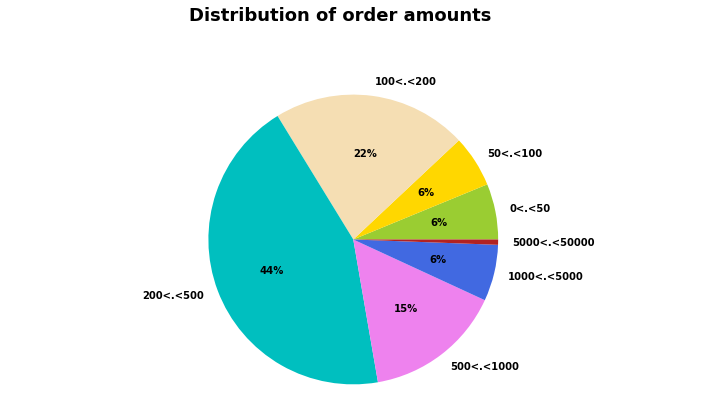

In [35]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i,price in enumerate(price_range):
    if i==0:continue
    val = basket_price[(basket_price['Basket Price'] < price)&
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18)
plt.show()

##### Analyzing product Description :

In [36]:
is_noun = lambda pos:pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    import nltk
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()
    keywords_select = dict()
    category_keys = []
    count_keywords = dict()
    icount = 0
    
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
        
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            
            category_keys.append(clef)
            keywords_select[s] = clef
        
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print("Number of keywords in the variable '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [37]:
df_produits = pd.DataFrame(data['Description'].unique()).rename(columns = {0:"Description"})

In [38]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Number of keywords in the variable 'Description': 1483


In [39]:
# Plotting keywords vs frequency graph :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    list_products.append([word, v])

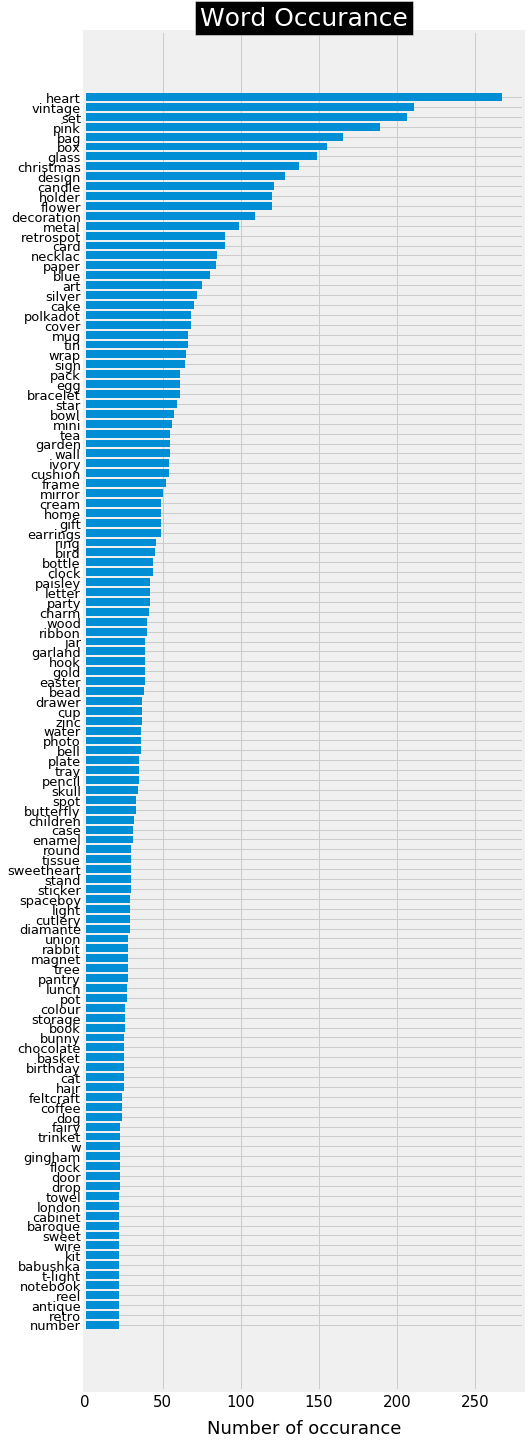

In [40]:
liste = sorted(list_products, key = lambda x:x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurance", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Word Occurance", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()

In [41]:
# Preserving important words :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word)<3 or v<13: continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x:x[1], reverse=True)
print("Number of preserved words : ", len(list_products))

Number of preserved words :  193


##### Descrining every product in terms of words present in the description :
1. We will only use the preserved words, this is just like Binary Bag of Words<br>
2. We need to convert this into a product matrix with products as rows and different words as columns. A cell contains a 1 if a particular product has that word in its description else it contains 0.
3. We will use this matrix to categorize the products.
4. We will add a mean price feature so that the groups are balanced.

In [42]:
threshold = [0, 1, 2, 3, 5, 10]

# Getting the description.
liste_produits = df_cleaned['Description'].unique()

# Creating the product and word matrix.
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
    

label_col = []
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
        
    label_col.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    
    while prix > threshold[j]:
        j += 1
        if j == len(threshold):
            break
    X.loc[i, label_col[j-1]] = 1

In [43]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


### Clustering :
1. KMEANS.

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [46]:
matrix = X.as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [47]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.10158702596012364
For n_clusters :  4 The average silhouette_score is :  0.1268004588393788
For n_clusters :  5 The average silhouette_score is :  0.14708700459493795
For n_clusters :  6 The average silhouette_score is :  0.14364428478713906
For n_clusters :  7 The average silhouette_score is :  0.14779720510063515
For n_clusters :  8 The average silhouette_score is :  0.1495445500379362
For n_clusters :  9 The average silhouette_score is :  0.15396340837064715


In [48]:
# Choosing number of clusters as 5:
# Trying Improving the silhouette_score :
n_clusters = 5
sil_avg = -1
while sil_avg < 0.145:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  5 The average silhouette_score is :  0.12120757081922832
For n_clusters :  5 The average silhouette_score is :  0.14740815062347604


In [49]:
# Printing number of elements in each cluster :
pd.Series(clusters).value_counts()

1    1009
0     964
2     673
3     626
4     606
dtype: int64

#### Analyzing the 5 clusters :

In [51]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    import matplotlib as mpl
    mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhoutte_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhoutte_values.sort()
        size_cluster_i = ith_cluster_silhoutte_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhoutte_values, alpha = 0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                 bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle = 'round, pad = 0.3'))
        
        y_lower = y_upper + 10

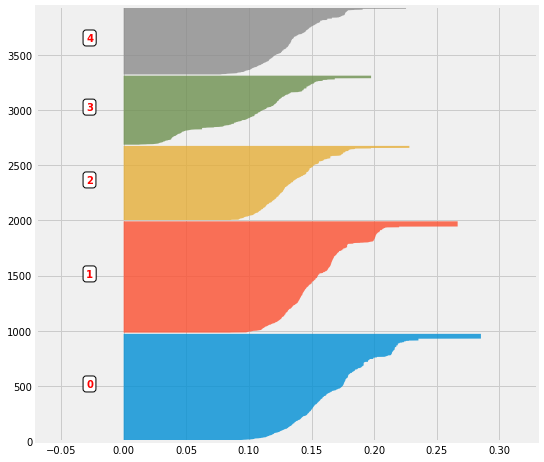

In [52]:
# Plotting the intra cluster silhouette distances.
from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [53]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurance) in list_products]

occurance = [dict() for _ in range(n_clusters)]

In [54]:
# Creating data for printing word cloud.
for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurance[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

In [55]:
# Code for printing word cloud.
from random import randint
import random
def random_color_func(word=None, font_size=None, position=None,orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [56]:
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurances = liste[0:150]
    for s in trunc_occurances:
        words[s[0]] = s[1]
        
    wc = wordcloud.WordCloud(width=1000,height=400, background_color='lightgrey', max_words=1628,relative_scaling=1,
                             color_func = random_color_func, normalize_plurals=False)
    wc.generate_from_frequencies(words)
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

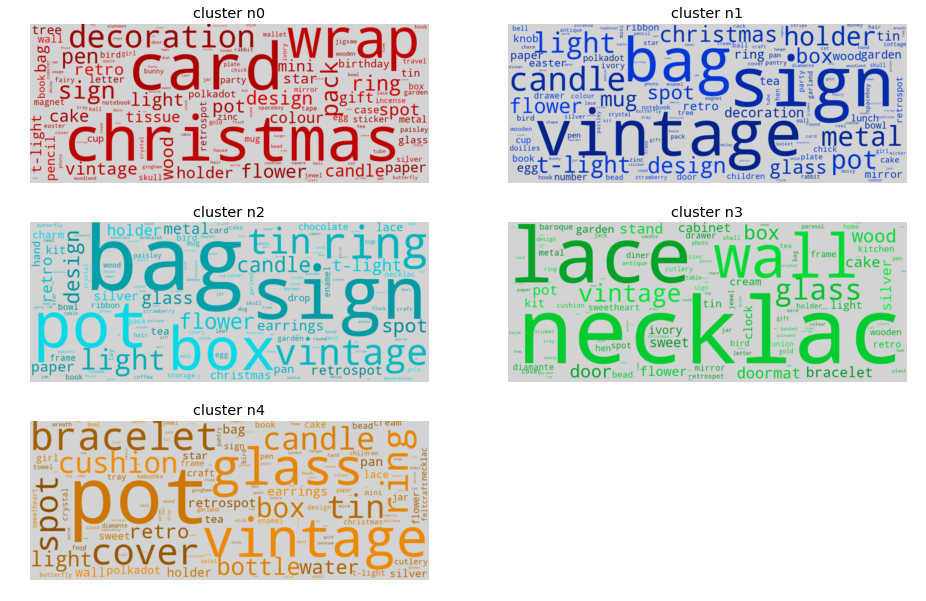

In [57]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurance[i]
    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

** Conclusions **
1. Cluster number two contains all the items related to decoration and gifts.
2. Cluster number 4 contains luxury items.
3. Words like Vintage are common to most of the clusters.

## Dimensionality Reduction:
> PCA

In [59]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

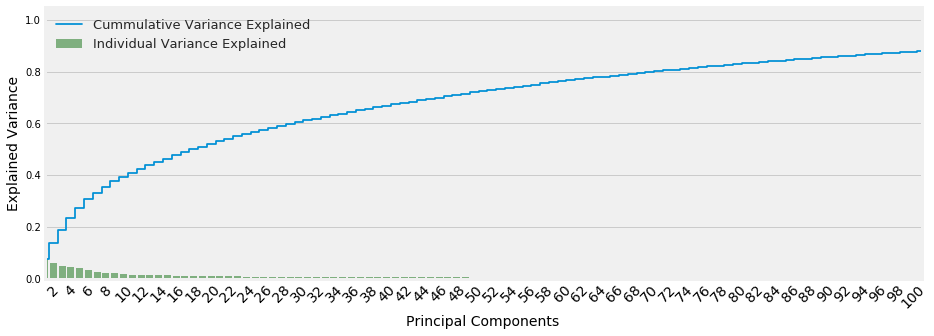

In [61]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 100)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

** We need more than 100 Principal Components to explain more than 90 % of the variance. **
<br>

## Generating Customer Segments/Categories :
1. We will use the already generated product categories and create a new feature which tells to which category the product belongs to.

In [62]:
corresp = dict()
for key, val in zip(liste_produits, clusters):
    corresp[key] = val
    
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2
1,536365,WHITE METAL LANTERN,4
2,536365,CREAM CUPID HEARTS COAT HANGER,4
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4
5,536365,SET 7 BABUSHKA NESTING BOXES,3
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,4
7,536366,HAND WARMER UNION JACK,2
8,536366,HAND WARMER RED POLKA DOT,1
9,536367,ASSORTED COLOUR BIRD ORNAMENT,1


In [63]:
# Creating 5 new features that will contain the amount in a single transanction on different categories of product.
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
    
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.00,15.3,0.0,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.00,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.00,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.00,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.00,0.0,0.0,20.34
5,536365,SET 7 BABUSHKA NESTING BOXES,3,0.0,0.00,0.0,15.3,0.00
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,4,0.0,0.00,0.0,0.0,25.50
7,536366,HAND WARMER UNION JACK,2,0.0,0.00,11.1,0.0,0.00
8,536366,HAND WARMER RED POLKA DOT,1,0.0,11.10,0.0,0.0,0.00
9,536367,ASSORTED COLOUR BIRD ORNAMENT,1,0.0,54.08,0.0,0.0,0.00


##### A single order is split into multiple entries we will basket them :

In [64]:
# sum of purchases by user and order.
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

# percentage spent on each product category 
for i in range(5):
    col = "categ_{}".format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:, col] = temp

# Dates of the order.
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# Selecting entries with basket price > 0.
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347.0,537626,711.79,23.40,187.2,83.40,124.44,293.35,2010-12-07 14:57:00.000001024
2,12347.0,542237,475.39,84.34,130.5,53.10,38.25,169.20,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,81.00,330.9,71.10,38.25,115.00,2011-04-07 10:42:59.999999232
4,12347.0,556201,382.52,41.40,74.4,78.06,19.90,168.76,2011-06-09 13:01:00.000000256
5,12347.0,562032,584.91,61.30,109.7,119.70,136.05,158.16,2011-08-02 08:48:00.000000000


In [65]:
basket_price['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [66]:
basket_price['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

##### Time Based Splitting :

In [68]:
import datetime
set_entrainment = basket_price[basket_price['InvoiceDate'] < datetime.date(2011, 10, 1)]
set_test = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011, 10, 1)]
basket_price = set_entrainment.copy(deep = True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until


##### Grouping Orders :
> We will get info about every customer on how much do they purchase, total number of orders. etc

In [70]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,29.836681,14.524555,12.787815,32.408290
1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,41.953217,0.000000,20.030714,0.000000
2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,48.444976,27.900718,11.961722,0.000000
3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,12.892120,3.370331,67.534402,15.711338
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,13.033708,19.887640,67.078652,0.000000


In [71]:
# Generating two new variables - days since first puchase and days since last purchase.
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transanctions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transanctions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

In [72]:
transanctions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,29.836681,14.524555,12.787815,32.408290,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,41.953217,0.000000,20.030714,0.000000,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,48.444976,27.900718,11.961722,0.000000,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,12.892120,3.370331,67.534402,15.711338,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,13.033708,19.887640,67.078652,0.000000,134,134


##### We need to focus on customers who only placed one order, our objective is to target these customers in a way to retains them.

In [73]:
n1 = transanctions_per_user[transanctions_per_user['count'] == 1].shape[0]
n2 = transanctions_per_user.shape[0]
print("No. of Customers with single purchase : {:<2}/{:<5} ({:<2.2f}%)".format(n1, n2, n1/n2*100))

No. of Customers with single purchase : 1445/3608  (40.05%)


##### Building Customer Segments :

In [75]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transanctions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print("Variable Mean Values: \n" + 90*'-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)

Variable Mean Values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  13.98907929
  25.22916919  21.19884856  23.21847344  16.37327913]


In [77]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

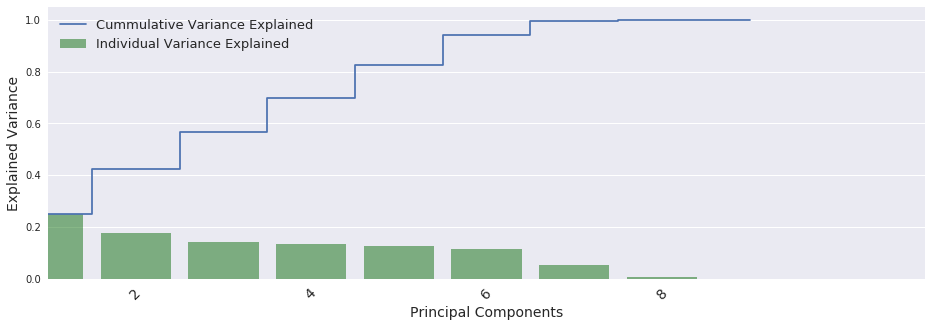

In [78]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 10)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

In [79]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 21):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.1595269499178677
For n_clusters :  4 The average silhouette_score is :  0.15228322459106527
For n_clusters :  5 The average silhouette_score is :  0.17659190270790093
For n_clusters :  6 The average silhouette_score is :  0.176090491223852
For n_clusters :  7 The average silhouette_score is :  0.1943722051474892
For n_clusters :  8 The average silhouette_score is :  0.20040025573549428
For n_clusters :  9 The average silhouette_score is :  0.20563343855986668
For n_clusters :  10 The average silhouette_score is :  0.21145681875731975
For n_clusters :  11 The average silhouette_score is :  0.21710098990501678
For n_clusters :  12 The average silhouette_score is :  0.19725151374296243
For n_clusters :  13 The average silhouette_score is :  0.18650226785182022
For n_clusters :  14 The average silhouette_score is :  0.18817898917433004
For n_clusters :  15 The average silhouette_score is :  0.18754777307885387
For n_clusters :  16 Th

In [80]:
# Choosing number of clusters as 10:
# Trying Improving the silhouette_score :
n_clusters = 10
sil_avg = -1
while sil_avg < 0.208:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  10 The average silhouette_score is :  0.21143966951332444


In [81]:
n_clusters = 10
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print("Silhouette Score : {:<.3f}".format(silhouette_avg))

Silhouette Score : 0.212


In [82]:
# Looking at clusters :
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns=['Number of Clients']).T

,1,4,8,3,0,7,2,5,9,6
Number of Clients,1490,538,455,347,302,231,200,22,12,11


> There is a large difference in cluster segments, We will analyze these clusters further.

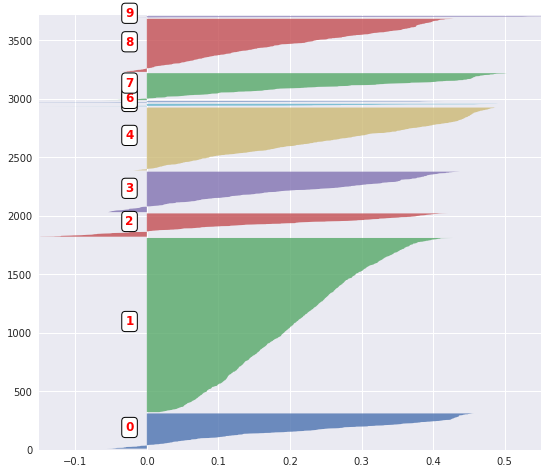

In [83]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

From this above graph we can rest assured that all the clusters are disjoint

##### Now we need to learn the habits of the customers to do that we will add the variables that define a cluster to which each customer belong:

In [84]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [85]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
    
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers : ', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

Number of customers :  3608


In [86]:
# Reorganizing the content of the dataframe.
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
    
liste_index_reordered = liste_index
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df.head()

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
0,7.0,2.177489,193.225281,316.770087,245.941610,578.891342,57.572268,18.055220,10.917728,7.424461,6.030323,99.510823,167.878788,231
1,8.0,2.437363,214.556110,327.029013,267.820454,690.938837,12.602321,57.482036,12.711180,9.426897,7.780838,103.142857,173.501099,455
2,0.0,2.993377,203.744371,401.593841,292.619882,1016.655596,6.903059,14.859204,60.690720,10.388264,7.158754,101.344371,198.642384,302
3,4.0,2.771375,200.766916,354.657509,264.473733,784.532809,4.936924,11.414943,11.194384,61.166753,11.297485,114.892193,189.018587,538
4,3.0,2.178674,213.443285,359.782795,275.470636,712.344611,6.499488,13.856293,14.265234,16.970152,48.453471,106.616715,168.616715,347


##### Saving the selected customer dataframe and above dataframe to csv so that we do not need to do all this again :

In [87]:
selected_customers.to_csv("selected_customers.csv")

In [88]:
merged_df.to_csv("merged_df.csv")

## Classifying the Customers :

In [90]:
selected_customers = pd.read_csv('selected_customers.csv')
merged_df = pd.read_csv('merged_df.csv')

##### Defining Helper Functions :

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
class Class_Fit(object):
    def __init__(self, clf, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} %".format(100 * accuracy_score(Y, self.predictions)))

In [92]:
selected_customers.head()

,Unnamed: 0,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,29.836681,14.524555,12.787815,32.408290,59,297,1
1,1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,41.953217,0.000000,20.030714,0.000000,5,288,7
2,2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,48.444976,27.900718,11.961722,0.000000,240,240,8
3,3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,12.892120,3.370331,67.534402,15.711338,2,226,4
4,4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,13.033708,19.887640,67.078652,0.000000,134,134,4


In [93]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

##### Train, Test Splitting :

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Training Models :

In [97]:
from sklearn.svm import LinearSVC


In [98]:
svc = Class_Fit(clf=LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [99]:
svc.grid_fit(X=X_train, Y=Y_train)
svc.grid_predict(X_test, Y_test)

Precision: 83.38 %


Confusion matrix, without normalization
[[ 55  14   0   0   0   0   0   0   0   0]
 [  0 284   0   0   0   0   0   1   2   0]
 [  1  36   0   0   1   0   0   0   1   0]
 [  0  13   0  48   0   0   0   0   0   0]
 [  0  19   0   0  90   0   0   0   1   0]
 [  0   3   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0  36   0   0]
 [  0  23   0   0   0   0   0   0  89   0]
 [  0   0   0   0   0   0   0   1   0   0]]


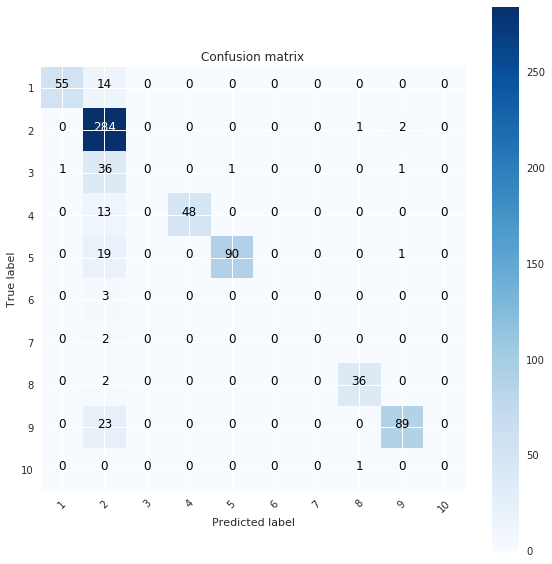

In [100]:
from sklearn.metrics import confusion_matrix
# code from -> SKLEARN Documentation.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
class_names = [i for i in range(1,11)]
cnf = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [101]:
# Code from sklearn documentation.
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

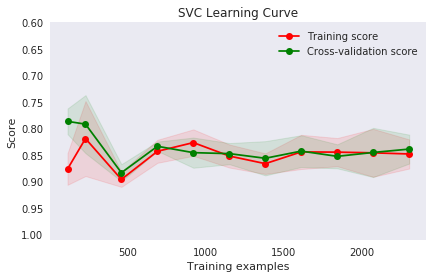

In [102]:
g = plot_learning_curve(svc.grid.best_estimator_, "SVC Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Logistics Regression :

In [103]:
from sklearn.linear_model import LogisticRegression

In [104]:
lr = Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-1,2,10)}], Kfold = 5)
lr.grid_fit(X_train, Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 90.86 %


Confusion matrix, without normalization
[[ 63   5   0   0   1   0   0   0   0   0]
 [  0 280   0   0   4   0   0   1   2   0]
 [  1  24  11   0   2   0   0   0   1   0]
 [  0   5   0  56   0   0   0   0   0   0]
 [  0   1   0   0 109   0   0   0   0   0]
 [  0   2   0   1   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0  36   0   0]
 [  0  11   0   0   0   0   0   0 101   0]
 [  0   0   0   0   0   0   0   1   0   0]]


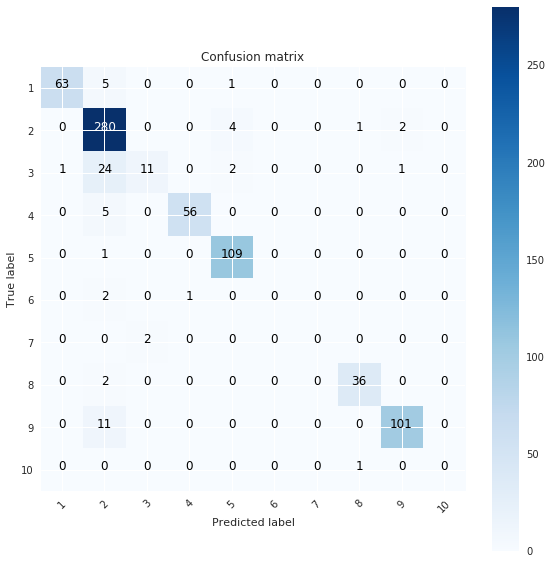

In [105]:
cnf = confusion_matrix(Y_test, lr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

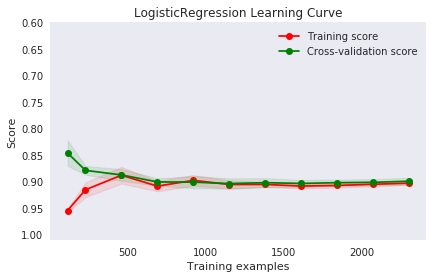

In [106]:
g = plot_learning_curve(lr.grid.best_estimator_, "LogisticRegression Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [107]:
#### K-Nearest Neighbours :

In [108]:
from sklearn.neighbors import KNeighborsClassifier

In [109]:
knn = Class_Fit(clf = KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors':np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X_train, Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 84.63 %


Confusion matrix, without normalization
[[ 56  10   1   0   1   0   0   0   1   0]
 [  5 262   8   2   4   0   0   1   5   0]
 [  0   7  32   0   0   0   0   0   0   0]
 [  1  12   0  44   2   0   0   0   2   0]
 [  0   9   0   0 101   0   0   0   0   0]
 [  0   2   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   1]
 [  0   7   0   0   0   0   0  30   1   0]
 [  0  25   1   1   0   0   0   1  84   0]
 [  0   0   0   0   0   0   0   0   0   1]]


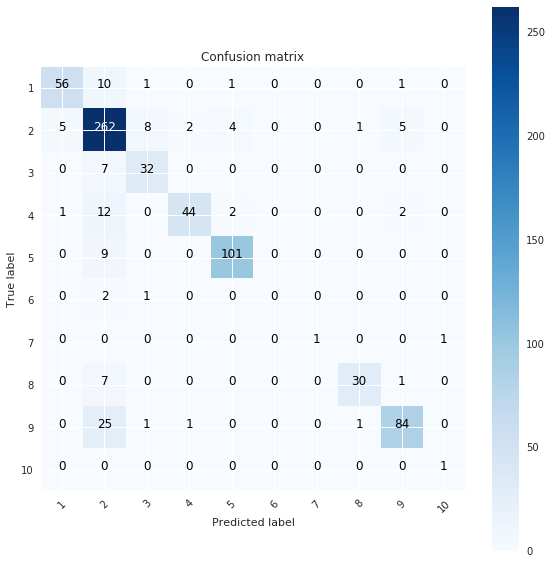

In [110]:
cnf = confusion_matrix(Y_test, knn.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

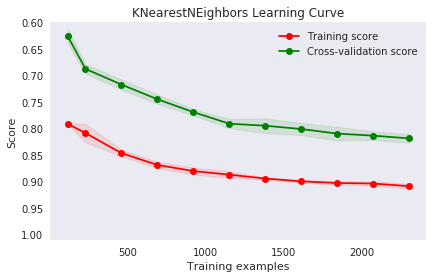

In [111]:
g = plot_learning_curve(knn.grid.best_estimator_, "KNearestNEighbors Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Decision Trees :

In [112]:
from sklearn.tree import DecisionTreeClassifier

In [113]:
tr = Class_Fit(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X_train, Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 90.86 %


Confusion matrix, without normalization
[[ 66   0   0   1   2   0   0   0   0   0]
 [  0 264   6   4   7   2   0   0   4   0]
 [  0   6  25   2   1   3   1   0   0   1]
 [  0   2   0  56   1   0   0   0   2   0]
 [  0   1   0   0 106   1   0   0   1   1]
 [  0   1   1   1   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0  36   2   0]
 [  0   5   3   0   0   0   0   1 103   0]
 [  0   0   0   0   0   0   0   1   0   0]]


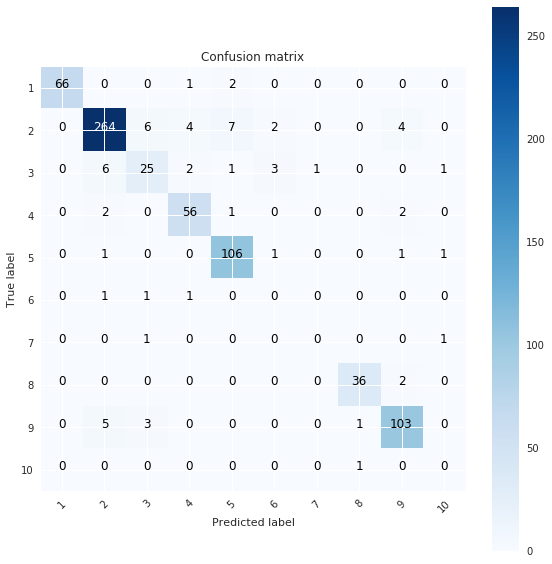

In [114]:
cnf = confusion_matrix(Y_test, tr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

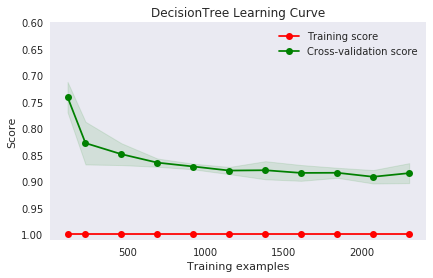

In [115]:
g = plot_learning_curve(tr.grid.best_estimator_, "DecisionTree Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])



#### Random Forests:

In [116]:
from sklearn.ensemble import RandomForestClassifier

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [117]:
rf = Class_Fit(clf = RandomForestClassifier)
rf.grid_search(parameters = [{'criterion':['entropy', 'gini'], 
                              'max_features':['sqrt', 'log2'], 'n_estimators':[20, 40, 60, 80, 100]}], Kfold = 5)
rf.grid_fit(X_train, Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 93.07 %


Confusion matrix, without normalization
[[ 64   3   0   0   2   0   0   0   0   0]
 [  0 262   9   3   9   0   0   2   2   0]
 [  1   4  31   2   1   0   0   0   0   0]
 [  0   2   0  59   0   0   0   0   0   0]
 [  0   0   0   0 110   0   0   0   0   0]
 [  0   1   1   1   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  37   0   0]
 [  0   3   0   0   0   0   0   0 109   0]
 [  0   0   0   0   0   0   0   1   0   0]]


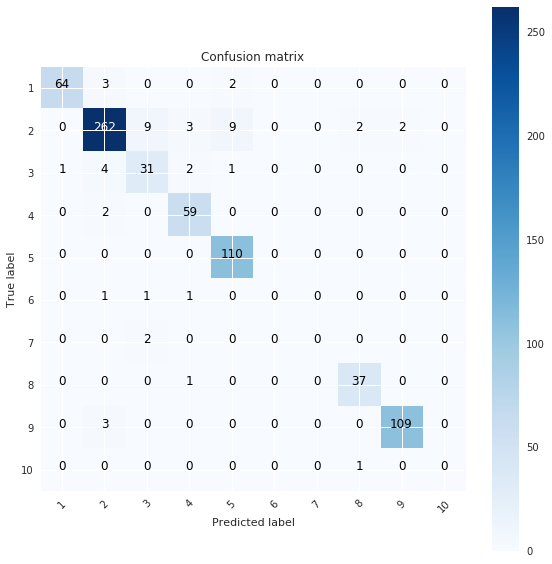

In [118]:
cnf = confusion_matrix(Y_test, rf.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

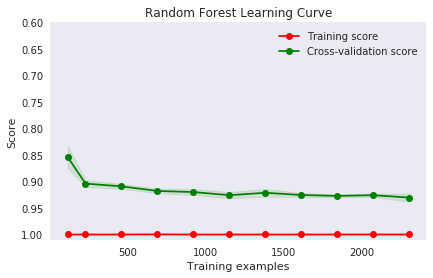

In [119]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


In [120]:
from sklearn.ensemble import AdaBoostClassifier

In [121]:
ada = Class_Fit(clf = AdaBoostClassifier)
ada.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
ada.grid_fit(X_train, Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 53.74 %


Confusion matrix, without normalization
[[  0  67   0   0   2   0   0   0   0   0]
 [  0 278   0   0   9   0   0   0   0   0]
 [  0  33   0   0   5   0   1   0   0   0]
 [  0  56   0   0   5   0   0   0   0   0]
 [  0   0   0   0 110   0   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0   0]
 [  0  38   0   0   0   0   0   0   0   0]
 [  0 111   0   0   1   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0]]


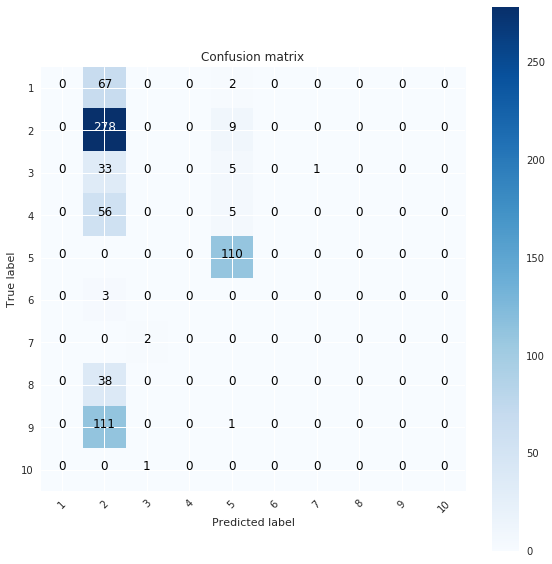

In [122]:
cnf = confusion_matrix(Y_test, ada.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

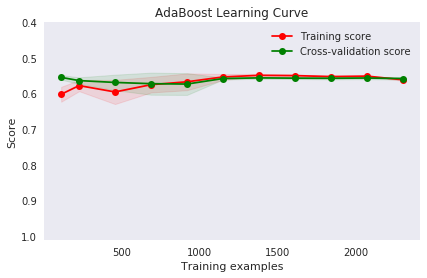

In [123]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost Learning Curve", X_train, Y_train, ylim=[1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])